In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("Warning CUDA not Found. Using CPU")

In [ ]:
#Data
print("> Setup dataset")

class OasisDataset(Dataset):
    """
        Custom PyTorch dataset for loading OASIS images and labels.

    Attributes (Where N - batch, C - channels, D - depth, H - height, W - width):
        images (torch.Tensor): Image tensors of shape (N, C, H, W).
        labels (torch.Tensor): Label tensors of shape (N, H, W, C) or (N, H, W).
    """
    def __init__(self, images, labels):
        # Convert to torch tensors and ensure channels-first format
        self.images = torch.from_numpy(images).permute(0, 3, 1, 2)  # (N, H, W, 1) → (N, 1, H, W)
        self.labels = torch.from_numpy(labels)  # (N, H, W, C) or (N, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
def load_training(path):
    """
    Load training images from the specified directory.
    """
    image_list = []
    for filename in glob.glob(path + "/*.png"):
        im = image.imread(filename)
        image_list.append(im)
    print("train_X shape:", np.array(image_list).shape)
    return np.array(image_list, dtype=np.float32)

def process_training(data_set):
    """
    Normalise and reshape training images.
    """
    data_set = data_set.astype(np.float32)
    if data_set.max() > 1.0:
        data_set = data_set / 255.0
    data_set = data_set[:, :, :, np.newaxis]  # (N, H, W, 1)
    return data_set

def load_labels(path):
    """
    Load label masks and map pixel values to integer class IDs.
    """
    image_list = []
    for filename in glob.glob(path + "/*.png"):
        im = image.imread(filename)
        one_hot = np.zeros((im.shape[0], im.shape[1]))
        for i, unique_value in enumerate(np.unique(im)):
            one_hot[:, :][im == unique_value] = i
        image_list.append(one_hot)
    print("train_y shape:", np.array(image_list).shape)
    return np.array(image_list, dtype=np.uint8)

def process_labels(seg_data):
    """
    Convert integer label masks into one-hot encoded format.
    """
    onehot_Y = []
    for n in range(seg_data.shape[0]):
        im = seg_data[n]
        n_classes = 4
        one_hot = np.zeros((im.shape[0], im.shape[1], n_classes), dtype=np.uint8)
        for i, unique_value in enumerate(np.unique(im)):
            one_hot[:, :, i][im == unique_value] = 1
        onehot_Y.append(one_hot)
    onehot_Y = np.array(onehot_Y)
    print("Labels shape:", onehot_Y.shape)
    return onehot_Y

> Setup dataset


In [ ]:
# Load and process the training data (images and labels)
train_X = process_training(load_training("oasis/keras_png_slices_data/keras_png_slices_train"))
# train_Y = process_labels(load_labels("oasis/keras_png_slices_data/keras_png_slices_seg_train"))

# Create a custom dataset for training with the processed images and labels
train_dataset = OasisDataset(train_X) #, train_Y)

# Initialize a DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_X = process_training(load_training("oasis/keras_png_slices_data/keras_png_slices_test"))
# test_Y = process_labels(load_labels("oasis/keras_png_slices_data/keras_png_slices_seg_test"))
test_dataset = OasisDataset(test_X) #, test_Y)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


train_X shape: (9664, 256, 256)
train_y shape: (9664, 256, 256)
Labels shape: (9664, 256, 256, 4)
train_X shape: (544, 256, 256)
train_y shape: (544, 256, 256)
Labels shape: (544, 256, 256, 4)


In [5]:
class CNNVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 256 → 128
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 128 → 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64 → 32
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32 → 16
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16 → 8
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Flatten()
        )

        self.fc_mu = nn.Linear(512 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(512 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 512 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 8, 8)),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8 → 16
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16 → 32
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32 → 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64 → 128
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 128 → 256
            nn.Sigmoid()  # Output in [0, 1] for image reconstruction
        )

    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder_conv(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu  # Use mean for inference. Using mu (mean) rather than sampling from the full distribution because:
                        # It provides deterministic, reproducible results
                        # The mean represents the "most likely" latent representation
                        # It avoids noise that could make interpolation less smooth

    def decode(self, z):
        """Decode latent variable to reconstruction"""
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction loss + KL divergence
    beta: weight for KL divergence (beta-VAE)
    """
    # Reconstruction loss (Binary Cross Entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    # KLD = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD, BCE, KLD

Training VAE...
Epoch [1/10], Loss: 21505.5900, BCE: 21416.8302, KLD: 88.7597


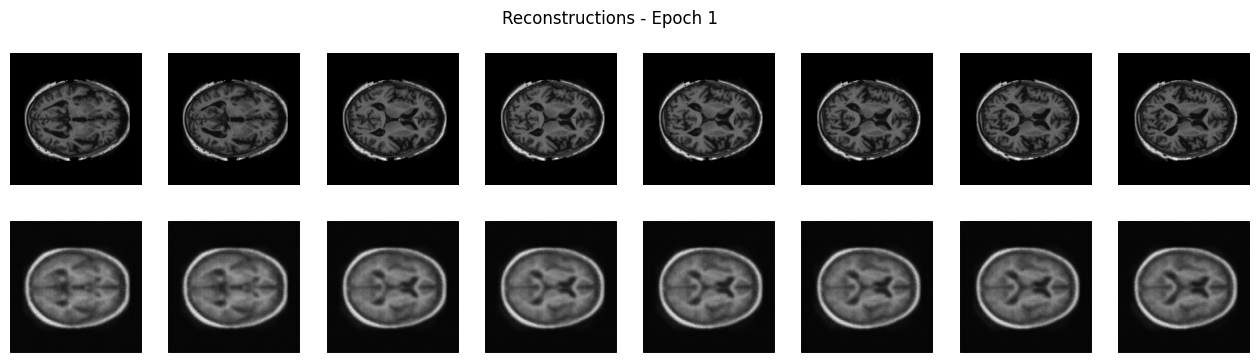

Epoch [2/10], Loss: 16906.5423, BCE: 16818.4622, KLD: 88.0800


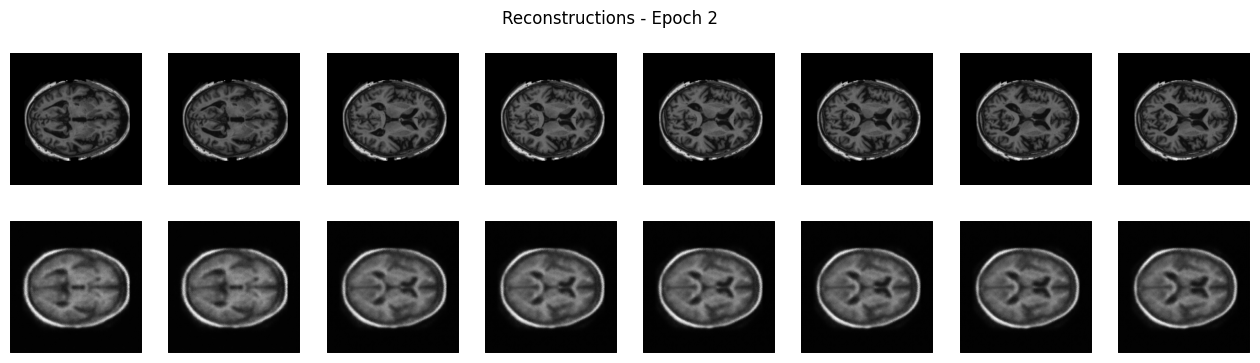

Epoch [3/10], Loss: 16434.5774, BCE: 16341.9633, KLD: 92.6140


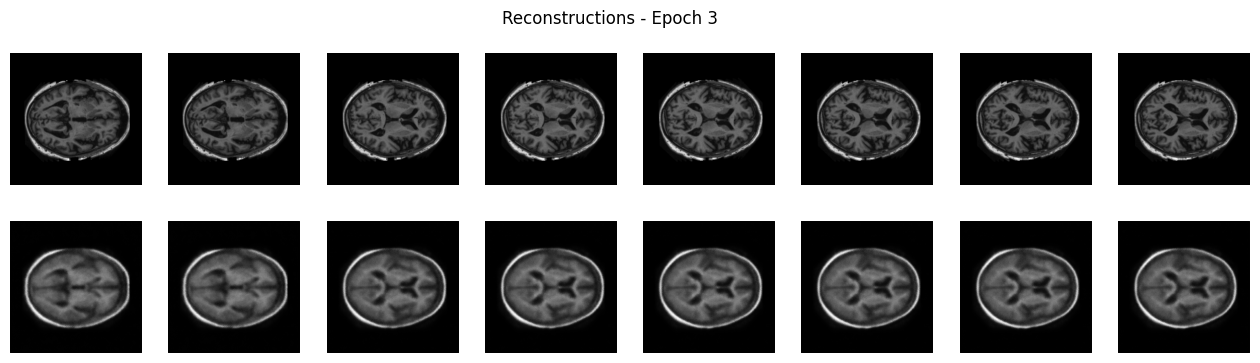

Epoch [4/10], Loss: 16264.4757, BCE: 16169.4892, KLD: 94.9866


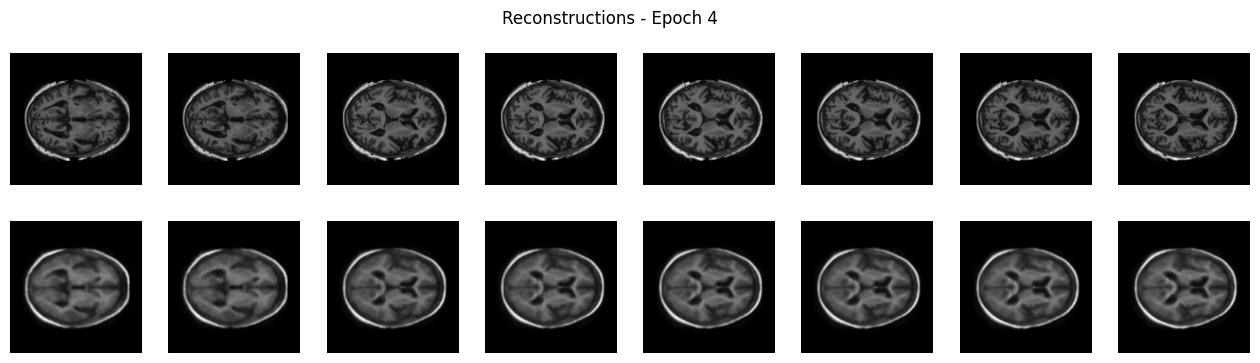

Epoch [5/10], Loss: 16175.4014, BCE: 16079.3408, KLD: 96.0607


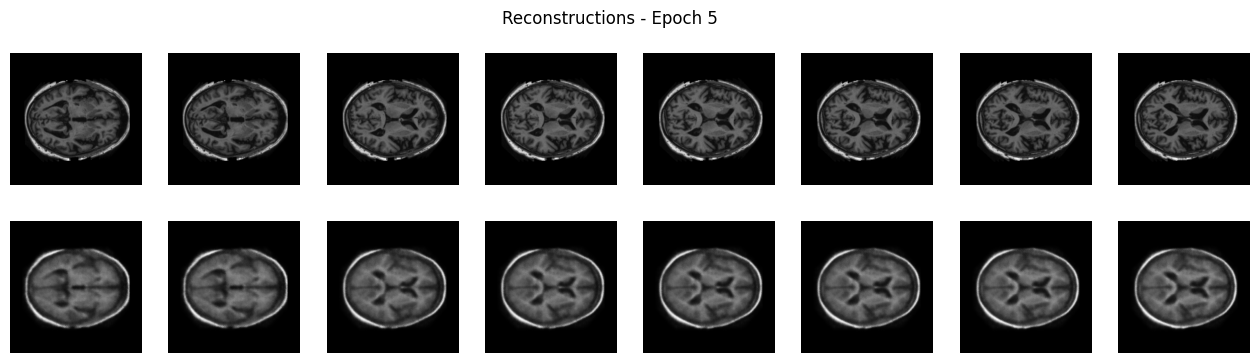

Epoch [6/10], Loss: 16120.0507, BCE: 16023.0201, KLD: 97.0306


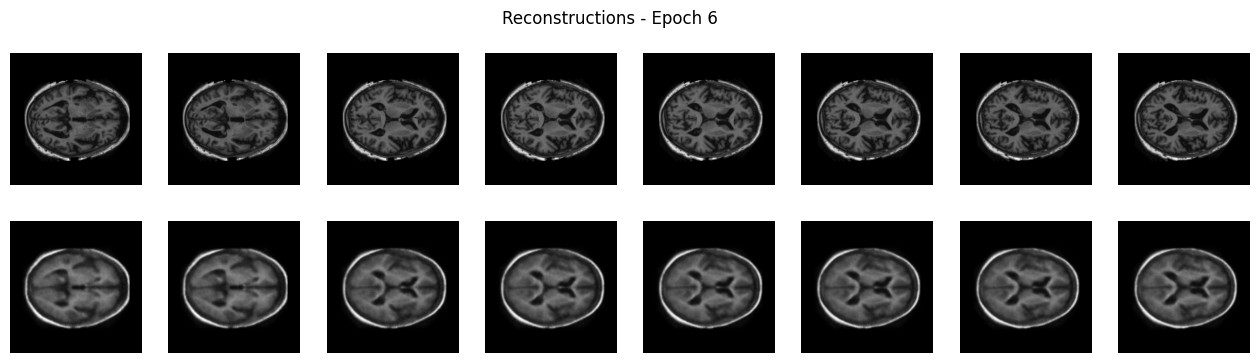

Epoch [7/10], Loss: 16081.1608, BCE: 15983.6767, KLD: 97.4841


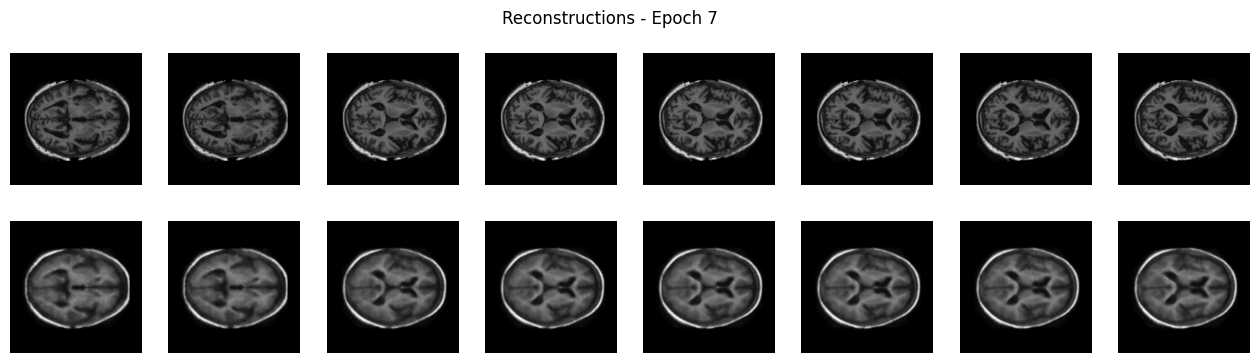

In [ ]:
# Training loop
num_epochs = 10
beta = 1.0  # Beta parameter for beta-VAE (1.0 = standard VAE)
learning_rate = 1e-4

# Train the VAE
vae = CNNVAE(latent_dim=64).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

print("Training VAE...")
for epoch in range(num_epochs):
    vae.train()
    total_loss = total_bce = total_kld = 0

    for images, _ in train_loader:
        images = images.to(device)

        recon_images, mu, logvar = vae(images)
        loss, bce, kld = vae_loss_function(recon_images, images, mu, logvar, beta)

        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}")

    # Reconstruction visualisation
    vae.eval()
    with torch.no_grad():
        test_images, _ = next(iter(test_loader))
        test_images = test_images.to(device)
        recon_images, _, _ = vae(test_images)

        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap="gray")
            axes[0, i].axis("off")
            if i == 0: axes[0, i].set_ylabel("Original")

            axes[1, i].imshow(recon_images[i].cpu().squeeze(), cmap="gray")
            axes[1, i].axis("off")
            if i == 0: axes[1, i].set_ylabel("Reconstructed")

        plt.suptitle(f"Reconstructions - Epoch {epoch+1}")
        plt.show()


In [ ]:
# Generate new samples from the VAE
print("Generating new samples from VAE...")
vae.eval()
with torch.no_grad():
    # Sample from standard normal distribution
    z = torch.randn(64, vae.latent_dim).to(device)
    generated_images = vae.decode(z)

    # Plot generated samples
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i in range(8):
        for j in range(8):
            idx = i * 8 + j
            axes[i, j].imshow(generated_images[idx].cpu().squeeze(), cmap='gray')
            axes[i, j].axis('off')

    plt.suptitle('Generated Samples from VAE', fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
import random
# Compare latent space interpolation
print("Latent space interpolation...")
vae.eval()
with torch.no_grad():
    # Get random batch of test images
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(device)

    # Randomly select two different digits
    available_indices = list(range(len(test_labels)))
    idx1 = random.choice(available_indices)

    # Find a different digit
    different_digits = [i for i in available_indices if test_labels[i] != test_labels[idx1]]
    if different_digits:
        idx2 = random.choice(different_digits)
    else:
        # Fallback if somehow all digits are the same (very unlikely)
        idx2 = (idx1 + 1) % len(test_labels)

    print(f"Interpolating between digit {test_labels[idx1].item()} and digit {test_labels[idx2].item()}")

    # Encode the two images
    mu1, _ = vae.encode(test_images[idx1:idx1+1])
    mu2, _ = vae.encode(test_images[idx2:idx2+1])

    # Interpolate between the two latent vectors
    n_steps = 10
    interpolated_images = []

    for i in range(n_steps):
        alpha = i / (n_steps - 1)
        z_interp = (1 - alpha) * mu1 + alpha * mu2
        img_interp = vae.decode(z_interp)
        interpolated_images.append(img_interp)

    # Plot interpolation
    fig, axes = plt.subplots(1, n_steps, figsize=(20, 2))
    for i in range(n_steps):
        axes[i].imshow(interpolated_images[i].cpu().squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Step {i+1}', fontsize=10)

    plt.suptitle(f'Latent Space Interpolation: Digit {test_labels[idx1]} → Digit {test_labels[idx2]}', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Create a 2D manifold visualization of digits
print("Creating 2D manifold of digits...")

def plot_digit_manifold(vae, n_grid=15, figsize=(15, 15)):
    """
    Plot a 2D manifold of digits by sampling from a grid in latent space
    """
    vae.eval()

    # Create a grid of points in 2D latent space
    # We'll use the first 2 dimensions of the latent space
    grid_x = np.linspace(-3, 3, n_grid)
    grid_y = np.linspace(-3, 3, n_grid)

    fig, axes = plt.subplots(n_grid, n_grid, figsize=figsize)

    # Randomly select which 2 dimensions to use for the manifold
    dim1 = np.random.randint(0, vae.latent_dim)
    dim2 = np.random.randint(0, vae.latent_dim)
    while dim2 == dim1:
        dim2 = np.random.randint(0, vae.latent_dim)

    print(f"Using latent dimensions {dim1} and {dim2} for manifold")

    with torch.no_grad():
        for i, y in enumerate(grid_y):
            for j, x in enumerate(grid_x):
                # Create latent vector with small random noise in other dimensions
                z = torch.randn(1, vae.latent_dim).to(device) * 0.1  # Small noise
                z[0, dim1] = x
                z[0, dim2] = y

                # Decode the latent vector
                decoded_img = vae.decode(z)

                # Plot the decoded image
                axes[i, j].imshow(decoded_img.cpu().squeeze(), cmap='gray')
                axes[i, j].axis('off')

    plt.suptitle('2D Manifold of Digits (Latent Space Dimensions 0 & 1)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Import numpy if not already imported
import numpy as np

# Create the manifold visualization
plot_digit_manifold(vae, n_grid=15)